In [1]:
%load_ext autoreload
%autoreload 2

from utils.prediction_models import *

In [2]:
DIR_data="/home/zeqianli/project/zeqian/Carbon/data"
zeqian=pd.read_pickle(f"{DIR_data}/zeqian/zeqian.pk")
matti=pd.read_pickle(f"{DIR_data}/matti/matti.pk")
bacdive=pd.read_pickle(f"{DIR_data}/bacdive/bacdive.pk")
datasets={"zeqian":zeqian,"matti":matti,"bacdive":bacdive,}

# bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")

# Figure 1

## 1B: data overview

ZL, Matti, BacDive data overview; combined tree

<AxesSubplot: ylabel='strain'>

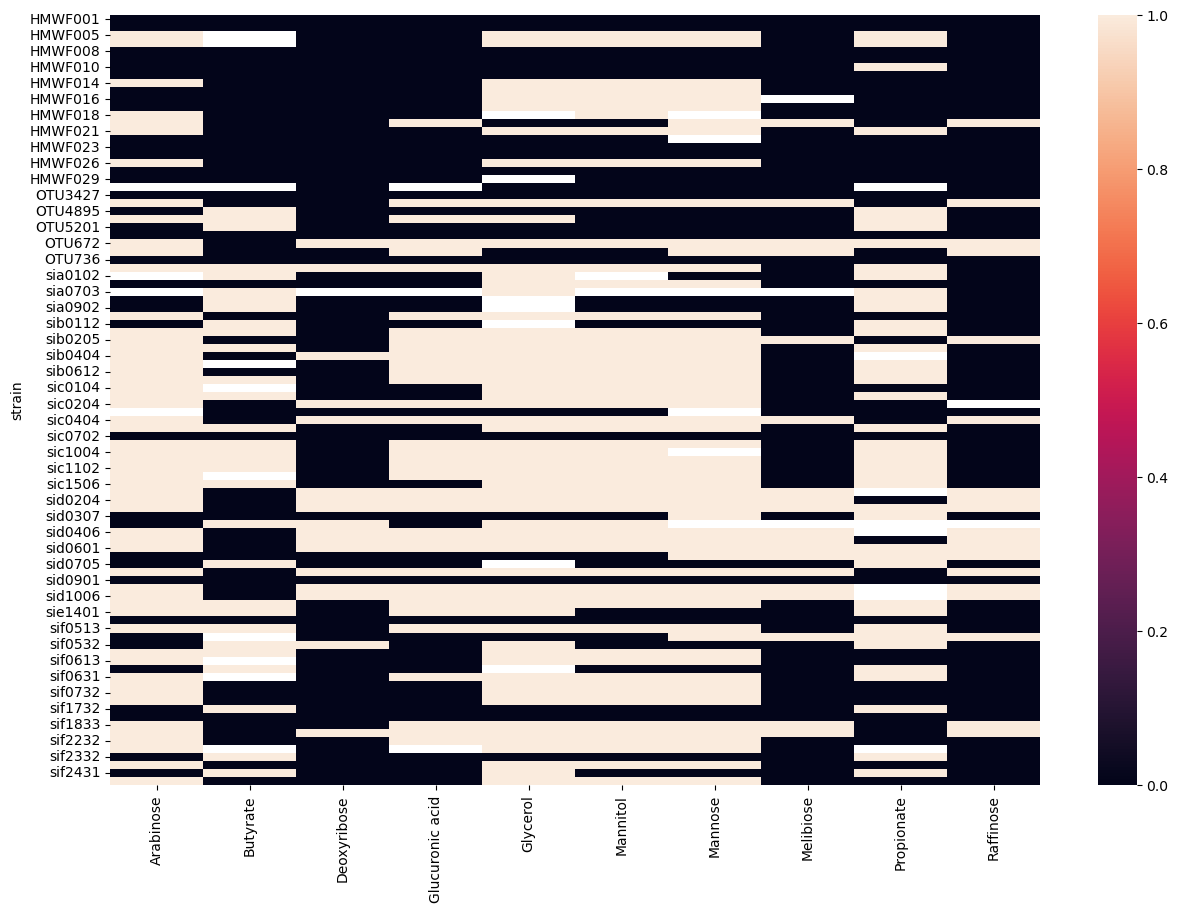

In [20]:
sns.heatmap(zeqian['growth_data'])

<AxesSubplot: >

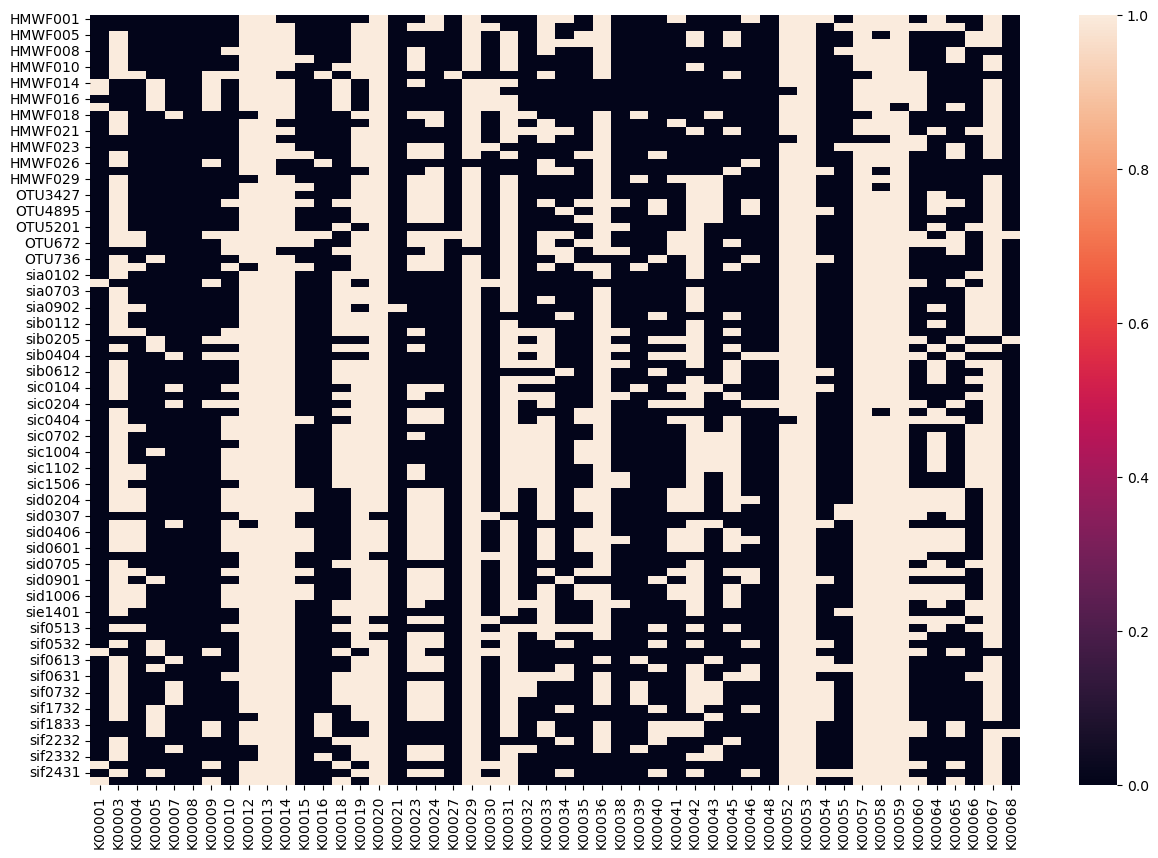

In [19]:
sns.heatmap(zeqian['ko_data'].iloc[:,:50])

In [4]:
zeqian['tree']

Tree node '' (0x7fb8d8a4b01)

In [10]:
os.environ['QT_QPA_PLATFORM']='offscreen'
zeqian['tree'].render("%%inline",h=200,w=200)

TypeError: super(type, obj): obj must be an instance or subtype of type

(<Figure size 1500x2000 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Tree'}>, <AxesSubplot: >],
       dtype=object))

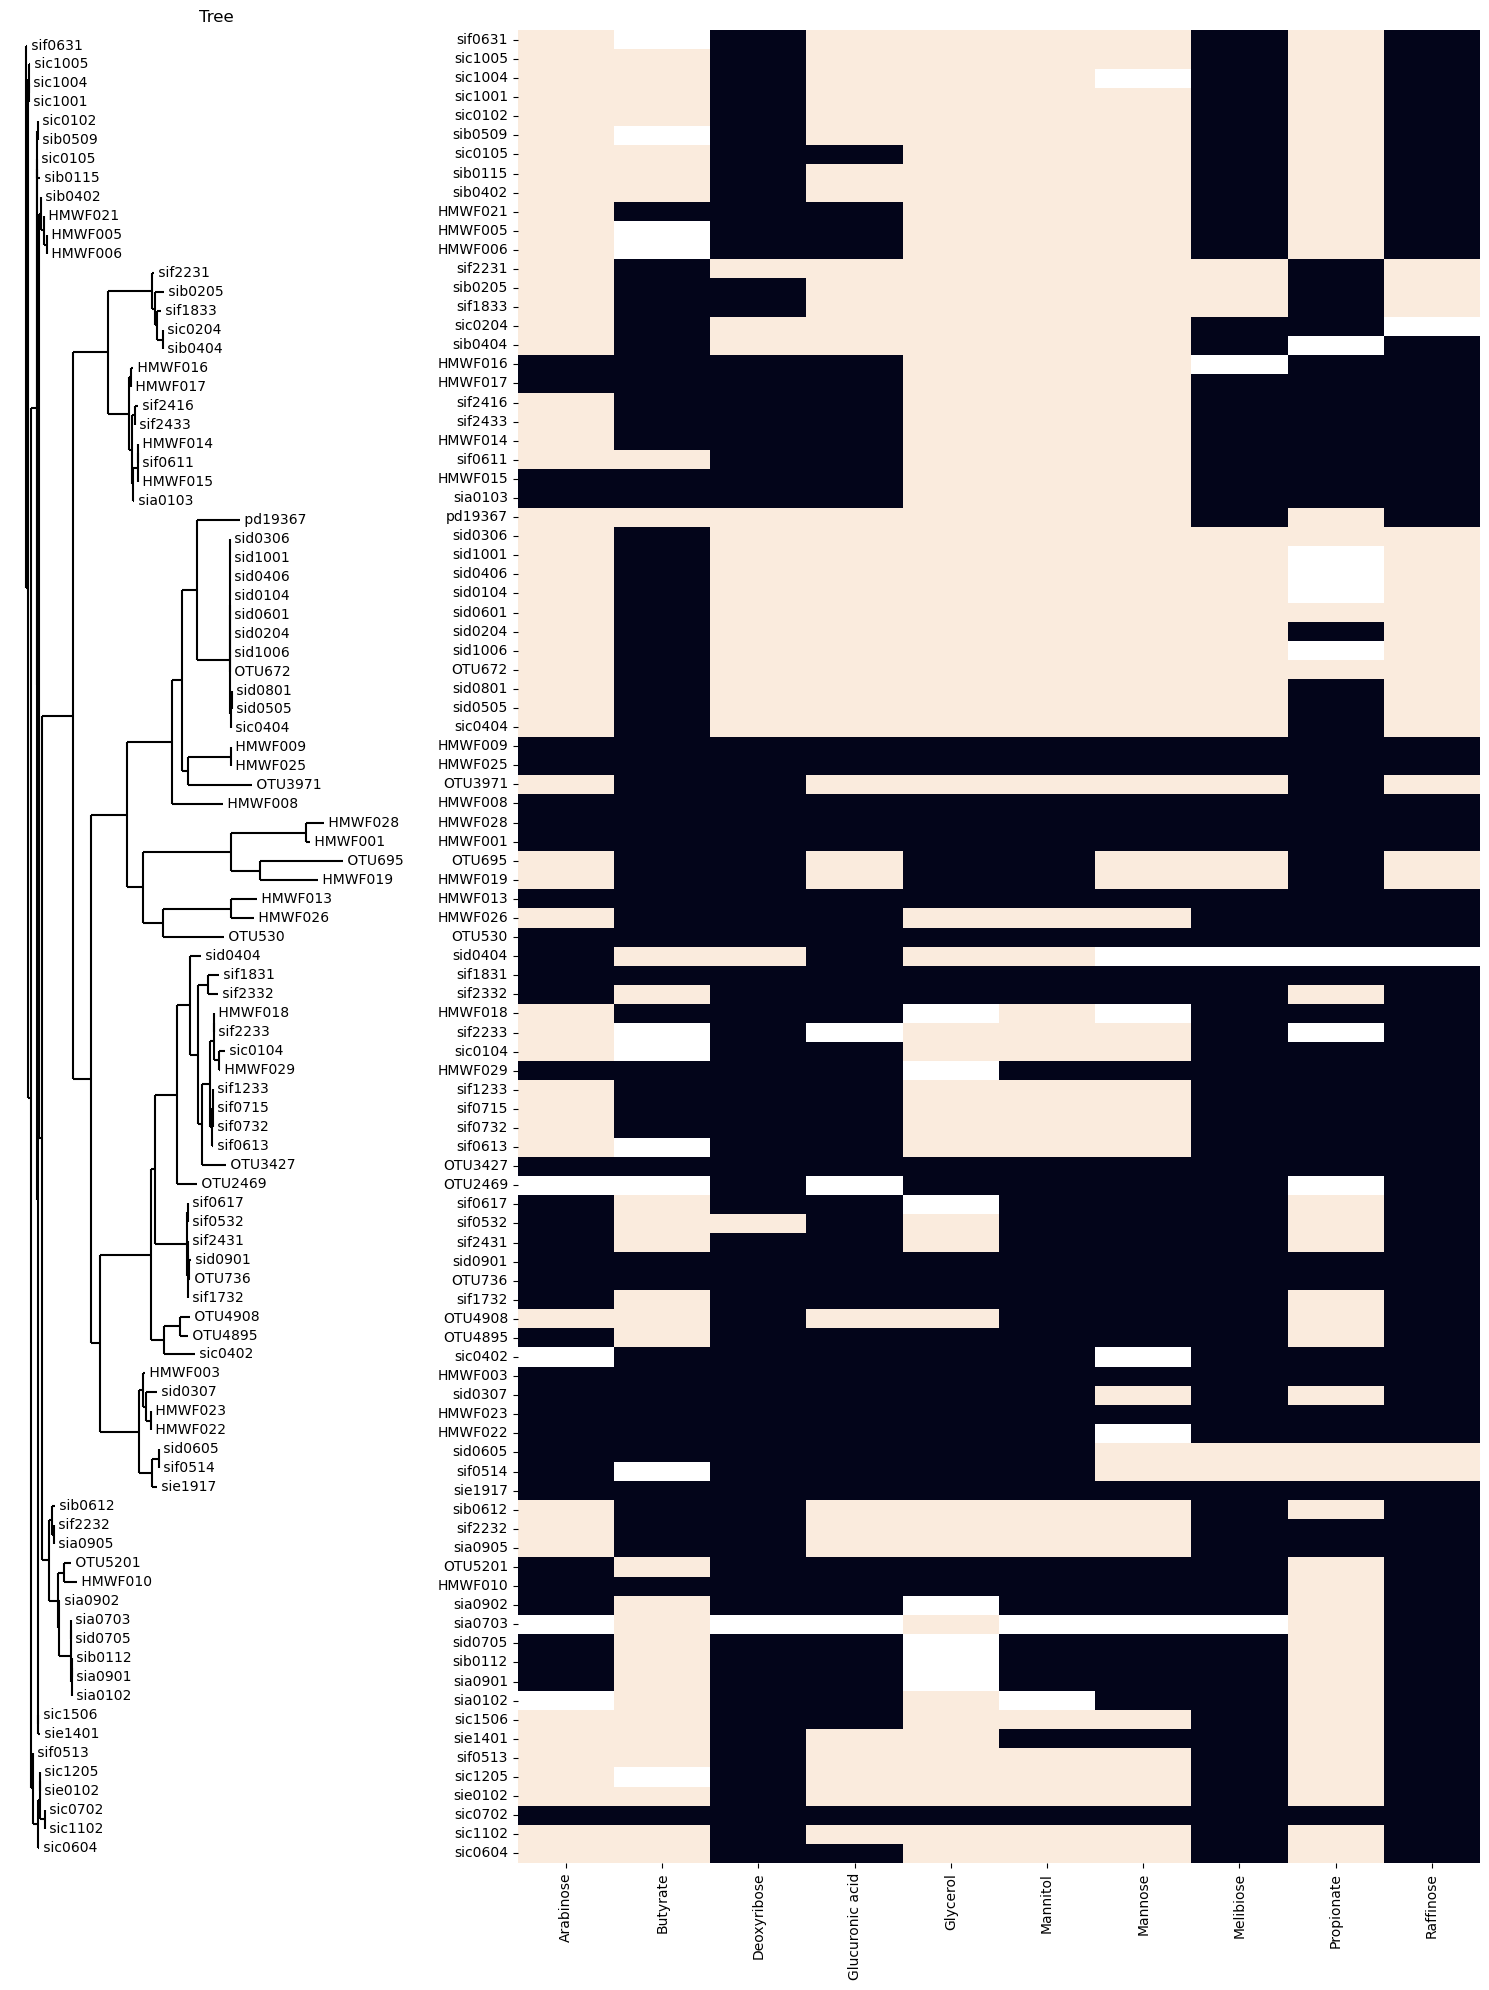

In [14]:
# Zeqian
plot_tree_matrix(zeqian['tree'], zeqian['growth_data'].iloc[:,:10],width_ratio=(3,7),cbar=False,
                    tree_params={'show_confidence':False})

In [17]:
matti['carbons'].shape

(118,)

(<Figure size 1500x2000 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Tree'}>, <AxesSubplot: >],
       dtype=object))

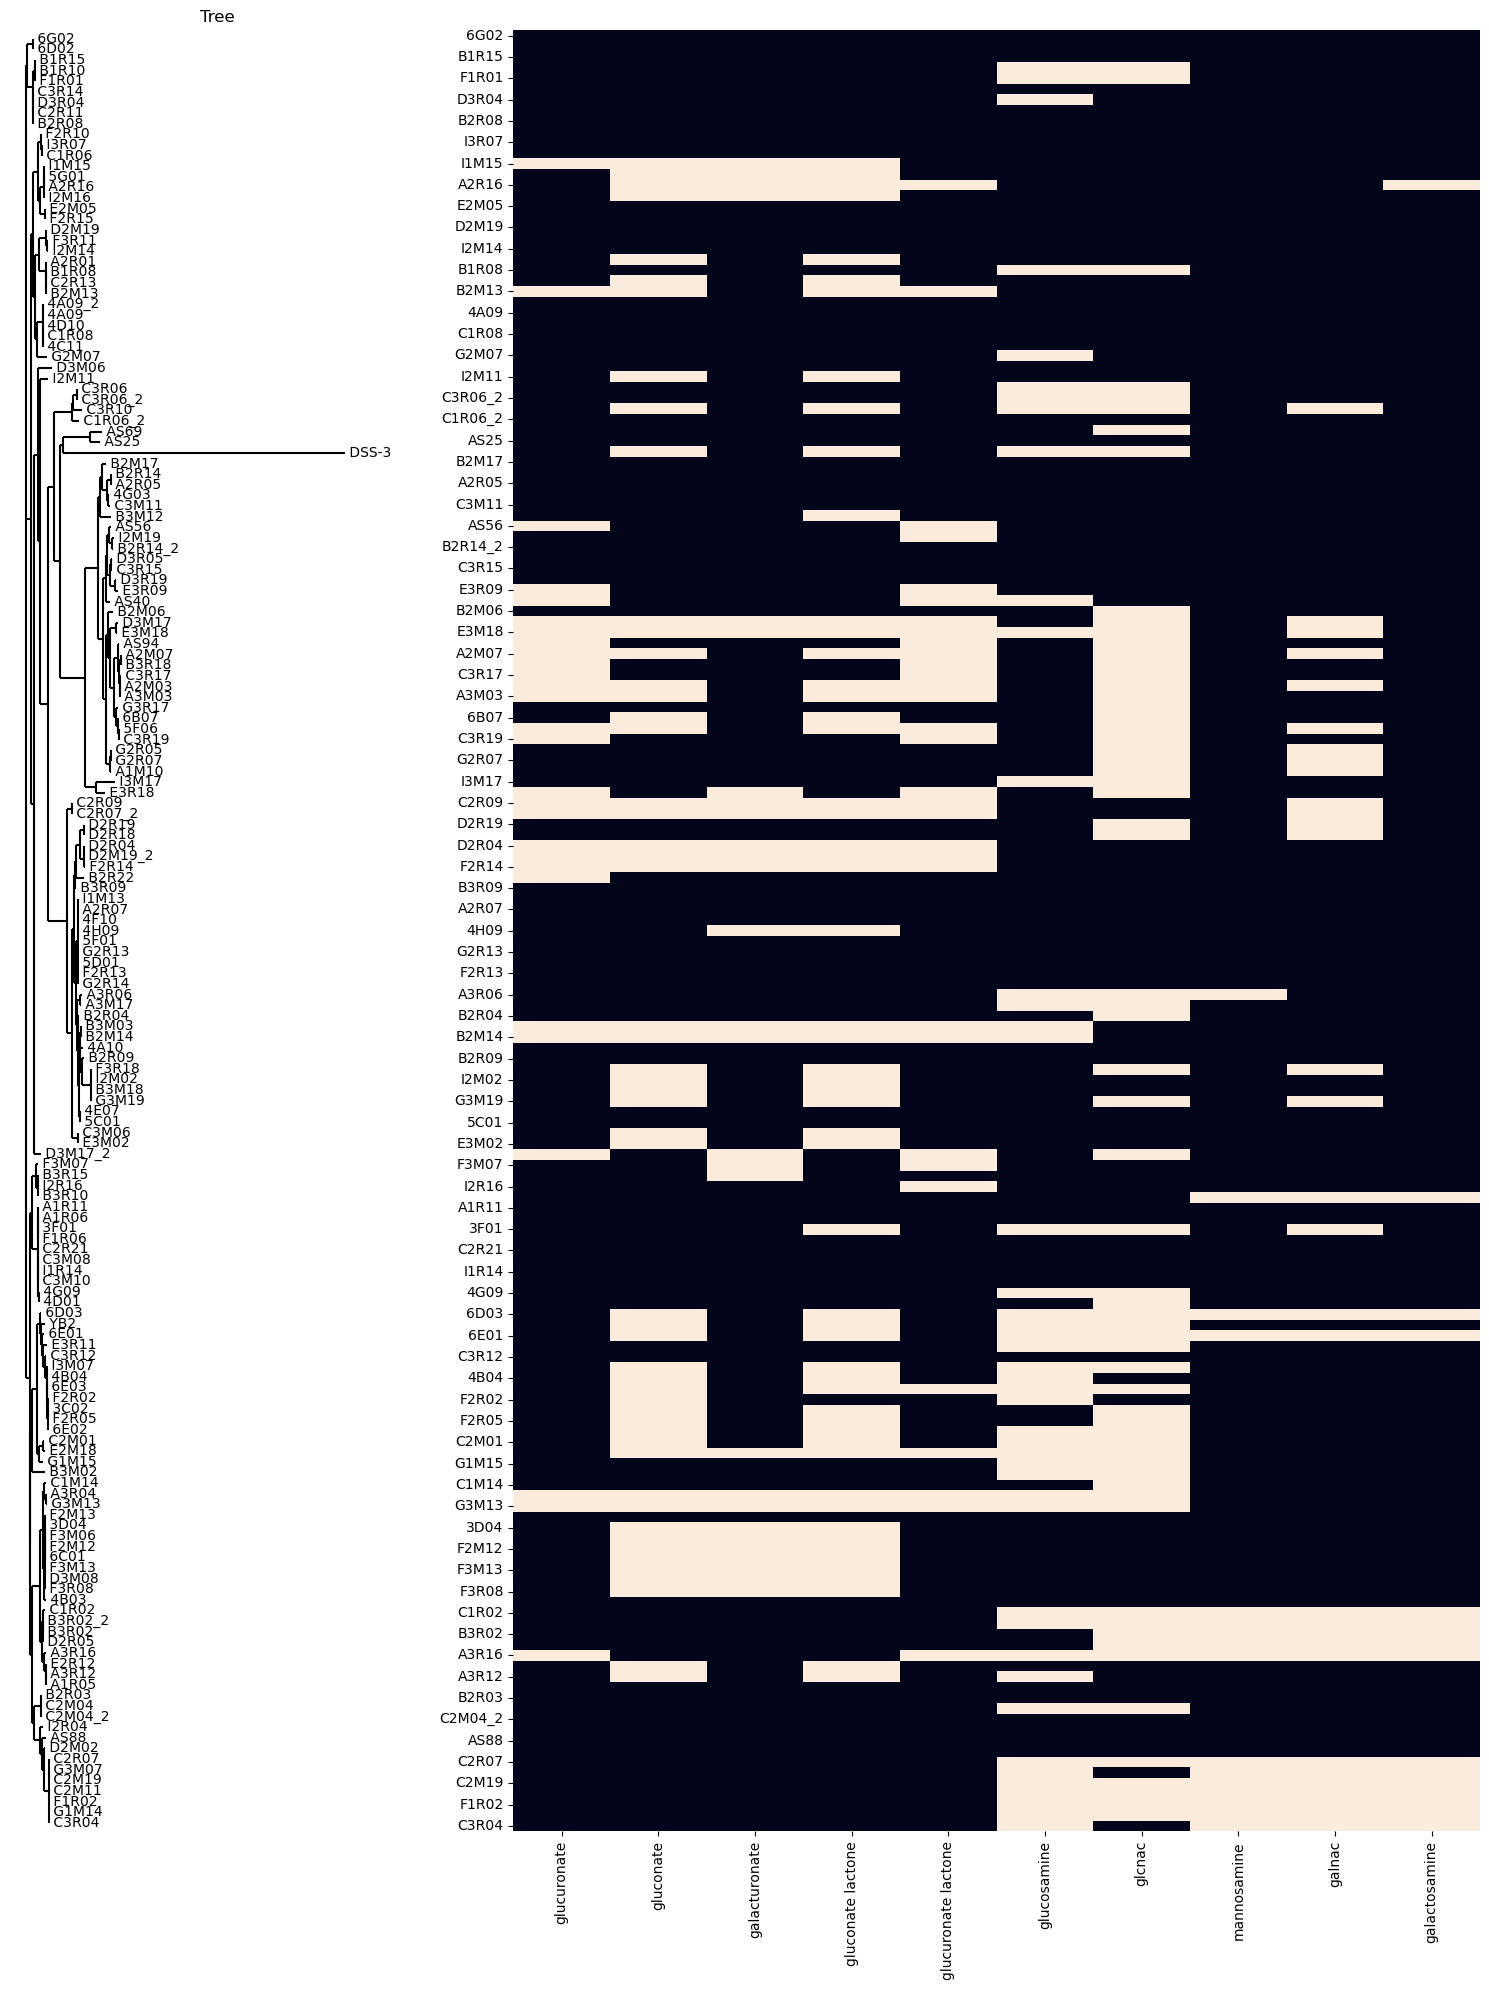

In [15]:
# Matti
plot_tree_matrix(matti['tree'], matti['growth_data'].iloc[:,:10],width_ratio=(3,7),cbar=False,tree_params={'show_confidence':False})

In [18]:
bacdive['growth_data'].shape

(4382, 220)

<AxesSubplot: xlabel='metabolite', ylabel='id'>

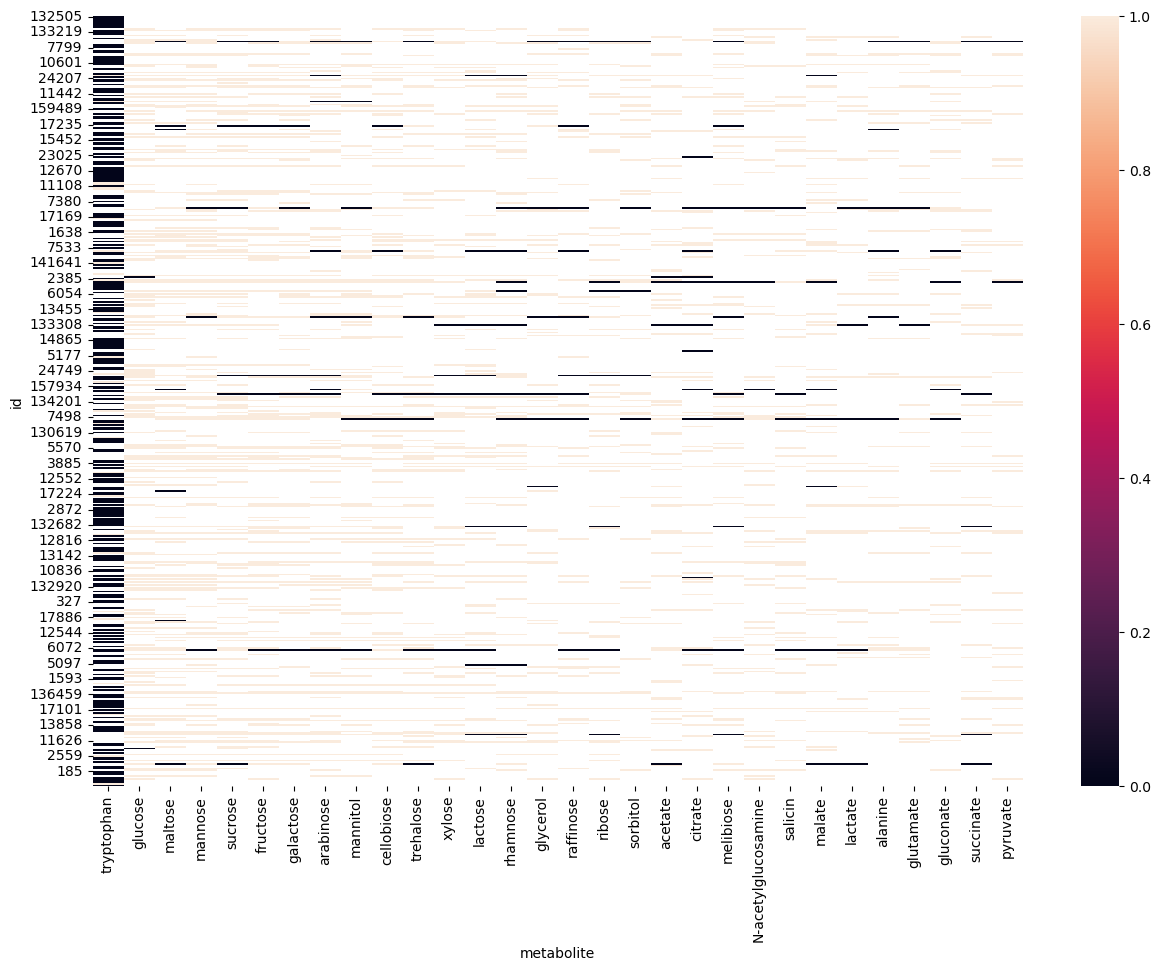

In [18]:
# Bacdive
df=bacdive['growth_data']
df=df.iloc[:,np.argsort(df.count(axis=0).values)[::-1]]

sns.heatmap(df.iloc[np.random.choice(df.shape[0],500),:30])

# Figure 2

## 2A: FBA, null, phylogeny models, ZL data, random partition

Left to right: null_bernoulli, FBA, 16S nearest neighbor, genome nearest neighbor 

In [8]:
# Zeqian
ko_data, growth_data, tree=zeqian['ko_data'],zeqian['growth_data'],zeqian['tree']
results_all=[]


# Zeqian 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
sixteenS_data=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
sixteenS_data.index=sixteenS_data.index.str.replace('zeqian_','')
sixteenS_data=sixteenS_data.loc[zeqian['samples']]

In [31]:
DIR_figure=f"{DIR_data}/figure_data/2A"


threads=1
models={'fba':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[growth_data.index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'fba_gapfill':[FBAClassifier,
                {'model_params':{c: {'c':c,
                                'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
                                'growth_threshold':0.05} for c in CARBONS},
                'split_method':{c:[growth_data.index.values] for c in CARBONS},
                'threads':1,
                'allow_empty_set':True,
                'save_models':False
                }
                ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':zeqian['tree'],
                 'save_models':False
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':zeqian['tree'],
                'save_models':False
                }
                ]
}

matrices={'zeqian_16s': [sixteenS_data,growth_data],
          'zeqian_genome': [ko_data,growth_data]
        }


In [32]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


Running zeqian_16s fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Running zeqian_genome fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.61it/s]


Running zeqian_16s fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


Running zeqian_genome fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 32.76it/s]

Running zeqian_16s null
Already exists. Skipping. 
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_16s null_ooc
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_16s NN
Already exists. Skipping. 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 


In [34]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [36]:
results_all.to_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")

[Text(0, 0, 'Arabinose'),
 Text(1, 0, 'Glucuronic acid'),
 Text(2, 0, 'Glycerol'),
 Text(3, 0, 'Mannitol'),
 Text(4, 0, 'Mannose'),
 Text(5, 0, 'Deoxyribose'),
 Text(6, 0, 'Melibiose'),
 Text(7, 0, 'Butyrate'),
 Text(8, 0, 'Propionate'),
 Text(9, 0, 'Raffinose')]

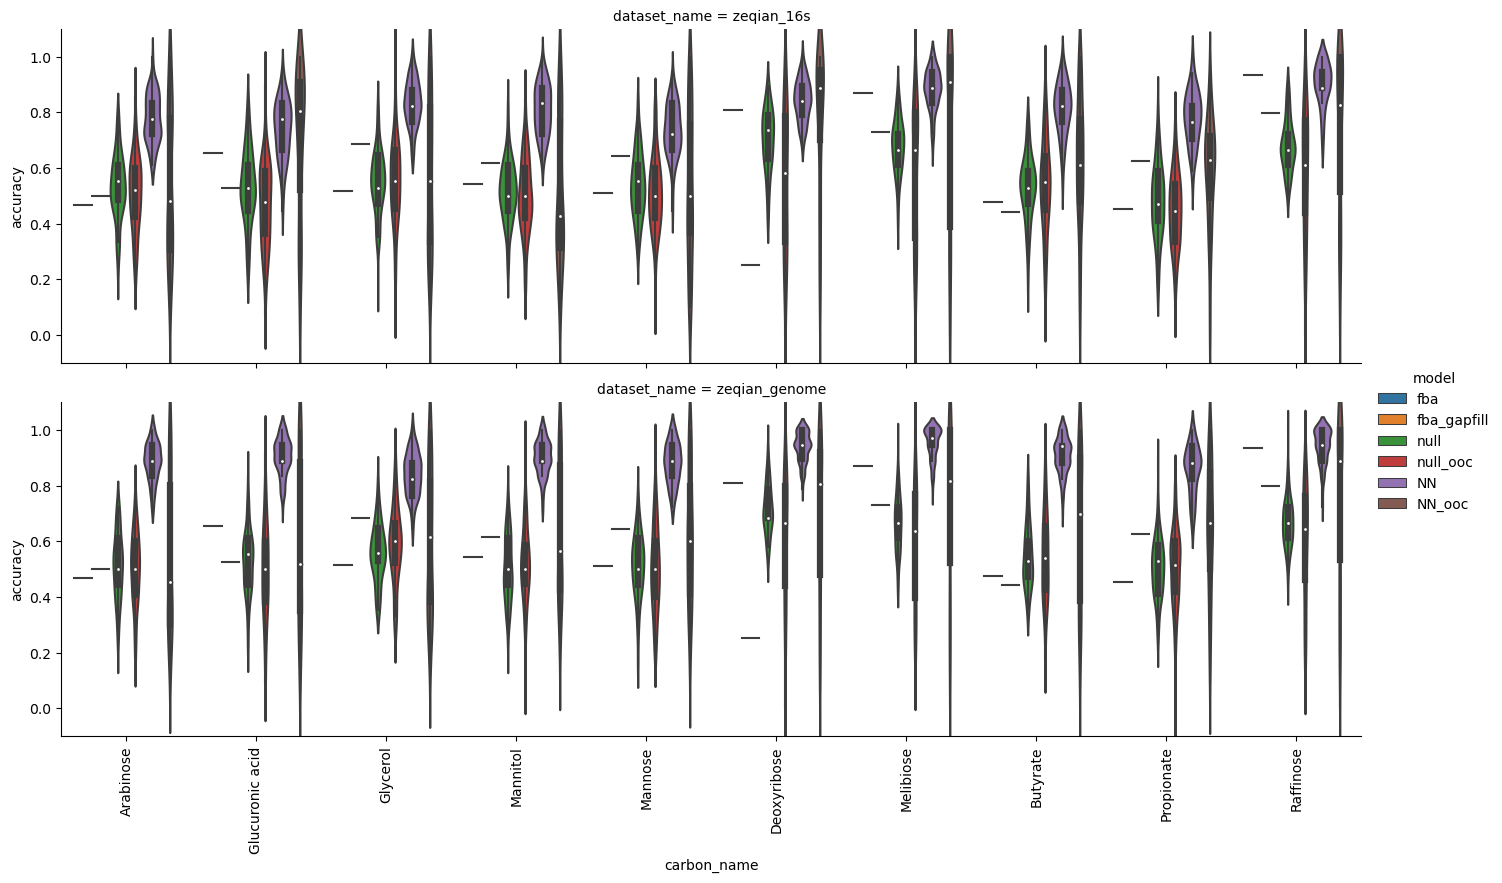

In [37]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
sns.catplot(data=results_all, x='carbon_name',y='accuracy',hue='model',kind='violin',dodge=True,height=4, aspect=3.5,row='dataset_name')
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
# ax.grid()
ax.set_ylim(-0.1,1.1)
# x axis rotate 90 degree
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


In [42]:
results_all

,carbon_name,train_samples,test_samples,growth_threshold,true_negative,false_positive,false_negative,true_positive,accuracy,precision,sensitivity,specificity,f1_score,balanced_accuracy,train_sample_size,test_sample_size,model,dataset_name,is_null_model,null_model,replace,n_neighbors,weights,metric
0,Arabinose,[],"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.05,37,0,49,6,0.467391,1.000000,0.109091,1.000000,0.196721,0.554545,0,92,fba,zeqian_16s,NaN,NaN,NaN,NaN,NaN,NaN
1,Glucuronic acid,[],"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.05,48,8,24,13,0.655914,0.619048,0.351351,0.857143,0.448276,0.604247,0,93,fba,zeqian_16s,NaN,NaN,NaN,NaN,NaN,NaN
2,Glycerol,[],"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.05,25,3,40,21,0.516854,0.875000,0.344262,0.892857,0.494118,0.618560,0,89,fba,zeqian_16s,NaN,NaN,NaN,NaN,NaN,NaN
3,Mannitol,[],"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.05,36,2,41,15,0.542553,0.882353,0.267857,0.947368,0.410959,0.607613,0,94,fba,zeqian_16s,NaN,NaN,NaN,NaN,NaN,NaN
4,Mannose,[],"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...",0.05,27,5,39,19,0.511111,0.791667,0.327586,0.843750,0.463415,0.585668,0,90,fba,zeqian_16s,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8035,Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF009, HMWF010, HMWF025, OTU3971, OTU5201, ...",NaN,14,0,12,0,0.538462,NaN,0.000000,1.000000,NaN,0.500000,68,26,NN_ooc,zeqian_genome,NaN,NaN,NaN,1.0,uniform,hamming
8036,Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF009, HMWF014, HMWF015, HMWF016, HMWF017, ...",NaN,11,0,3,1,0.800000,1.000000,0.250000,1.000000,0.400000,0.625000,79,15,NN_ooc,zeqian_genome,NaN,NaN,NaN,1.0,uniform,hamming
8037,Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF010, ...","[HMWF008, HMWF009, HMWF025, OTU3971, OTU672, p...",NaN,4,2,12,0,0.222222,0.000000,0.000000,0.666667,NaN,0.333333,76,18,NN_ooc,zeqian_genome,NaN,NaN,NaN,1.0,uniform,hamming
8038,Raffinose,"[HMWF001, HMWF003, HMWF005, HMWF006, HMWF008, ...","[HMWF010, OTU5201, sia0102, sia0703, sia0901, ...",NaN,11,0,0,0,1.000000,NaN,NaN,1.000000,NaN,NaN,83,11,NN_ooc,zeqian_genome,NaN,NaN,NaN,1.0,uniform,hamming


In [62]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2A/results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='zeqian_16s'], 
                    model_pairs=[
                        (('fba','null'),one_sample_test),
                        (('fba_gapfill','null'),one_sample_test),
                        (('NN','null'),ttest),
                        (('NN_ooc','null_ooc'),ttest)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2A/stat.pk")

TODO: scatter plot, put together with 2B. 

## 2B: distribution of model scores, three data sets

### Matti

In [65]:
# Matti
ko_data, growth_data, tree,carbons=matti['ko_data'],matti['growth_data'],matti['tree'],matti['carbons']
results_all=[]

# Matti 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
sixteenS_data=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
sixteenS_data.index=sixteenS_data.index.str.replace('matti_','')
sixteenS_data=sixteenS_data.loc[matti['samples']]

In [68]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
threads=48
p=None
# p=Pool(threads)

In [69]:
DIR_figure=f"{DIR_data}/figure_data/2B"
models={
        # 'fba':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons,
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':matti['tree'],
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':matti['tree'],
                'p':p,
                'save_models':False,
                'carbons':carbons
                }
                ]
}

matrices={'matti_16s': [sixteenS_data,growth_data],
          'matti_genome': [ko_data,growth_data]
        }


In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue

            pipe=PredictionPipeline(Model,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


Running zeqian_16s fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Running zeqian_genome fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.61it/s]


Running zeqian_16s fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


Running zeqian_genome fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 32.76it/s]

Running zeqian_16s null
Already exists. Skipping. 
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_16s null_ooc
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_16s NN
Already exists. Skipping. 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 


In [70]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [71]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

In [6]:
# p-value

f1=lambda arr1,arr2: ttest(arr1,arr2, p_threshold=0.05, force_positive_t=True)

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_results_all.pk")

stat=compare_models(results_all[results_all['dataset_name']=='matti_16s'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        ('NN','null',f1),
                        ('NN_ooc','null_ooc',f1),
                        ('NN',single_model_summary),
                        ('NN_ooc',single_model_summary),
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

#stat.to_pickle(f"{DIR_data}/figure_data/2B/matti_stat.pk")

In [7]:
stat

stat,carbon_name,NN_max,NN_mean,NN_min,NN_null_p,NN_null_significant,NN_null_t,NN_ooc_max,NN_ooc_mean,NN_ooc_min,NN_ooc_null_ooc_p,NN_ooc_null_ooc_significant,NN_ooc_null_ooc_t,NN_ooc_std,NN_std
0,3m2-oxybutyrate,0.969697,0.846667,0.727273,0.0,True,22.091518,1.0,0.794636,0.333333,0.0,True,6.808552,0.177412,0.058103
1,acetate,0.939394,0.820606,0.666667,0.0,True,32.147371,1.0,0.67956,0.195652,0.0,True,8.588318,0.197794,0.058081
2,adenine,1.0,0.975455,0.878788,0.000121,False,-3.936584,1.0,0.974517,0.823529,0.939916,False,-0.075471,0.027897,0.026658
3,agarose,1.0,0.918485,0.818182,0.0,True,8.612497,1.0,0.904969,0.529412,0.243895,False,1.168806,0.097196,0.037774
4,alanine,0.939394,0.794848,0.575758,0.0,True,24.57838,1.0,0.702642,0.318182,0.0,True,10.025253,0.211399,0.064689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,valine,1.0,0.872121,0.727273,0.0,True,19.766551,1.0,0.772314,0.363636,0.000005,True,4.717203,0.180002,0.048024
114,xylan,0.939394,0.763636,0.545455,0.0,True,10.224739,0.95,0.673863,0.3,0.84408,False,-0.197011,0.160747,0.065555
115,xylitol,1.0,0.960909,0.818182,0.269411,False,1.107527,1.0,0.955476,0.8,0.285234,False,1.07155,0.051249,0.035155
116,xyloglucan,1.0,0.954545,0.878788,0.443062,False,-0.768576,1.0,0.900939,0.133333,0.009945,False,-2.617928,0.153973,0.029845


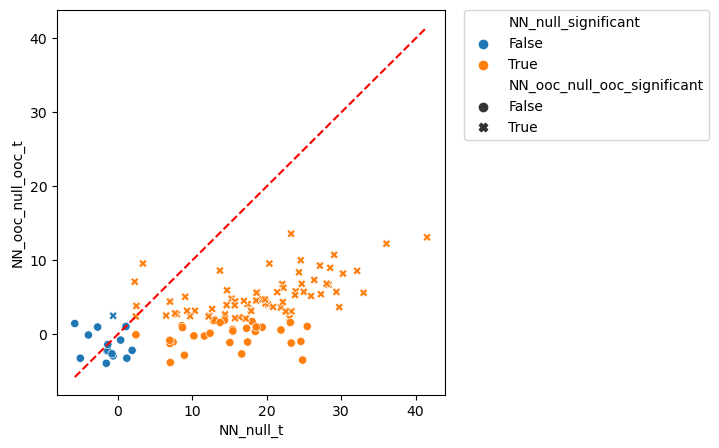

In [16]:
# Option 1
fig=plt.figure(figsize=(5,5))
sns.scatterplot(data=stat, x='NN_null_t',y="NN_ooc_null_ooc_t", hue='NN_null_significant', style='NN_ooc_null_ooc_significant')
# legend on the right outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# draw a line y=x
x=np.linspace(stat['NN_null_t'].min(),stat['NN_null_t'].max(),100)
plt.plot(x,x,'r--')


<AxesSubplot: xlabel='NN_ooc_null_ooc_t', ylabel='NN_ooc_mean'>

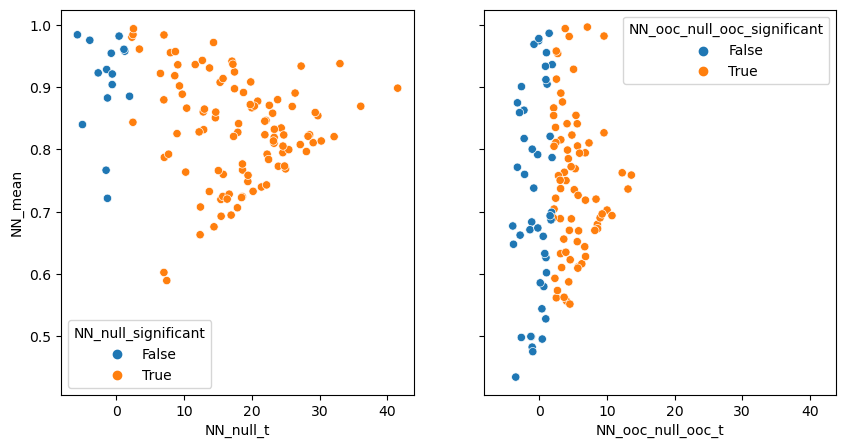

In [9]:
# Option 2
fig,axes=plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True)
sns.scatterplot(data=stat, x='NN_null_t',y="NN_mean", hue='NN_null_significant',ax=axes[0])
sns.scatterplot(data=stat, x='NN_ooc_null_ooc_t',y="NN_ooc_mean", hue='NN_ooc_null_ooc_significant',ax=axes[1])

Another option: x = mean_growth, y=NN_null_t

Also, how to deal with negative t stat? 

### BacDive

In [ ]:
# BacDive
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']
results_all=[]

#TODO: 16S for bacdive is too large. Need to use the pre-calcualted distance matrix for bacdive. Do this later. 

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
threads=48
p=Pool(threads)

In [ ]:
DIR_figure=f"{DIR_data}/figure_data/2B"
models={
        # 'fba':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        # 'fba_gapfill':[FBAClassifier,
        #         {'model_params':{c: {'c':c,
        #                         'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
        #                         'growth_threshold':0.05} for c in CARBONS},
        #         'split_method':{c:[growth_data.index.values] for c in CARBONS},
        #         'threads':1,
        #         'allow_empty_set':True,
        #         'save_models':False
        #         }
        #         ],
        'null': [BernoulliNull,
                {'model_params':{},
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons,
                 }],
        'null_ooc': [BernoulliNull,
                {'model_params':{},
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                 'n_splits':100,
                 'threads': threads,
                 'tree':bacdive['tree'],
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }],
                
        'NN':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'p':p,
                 'save_models':False,
                 'carbons':carbons
                 }
              ],
        'NN_ooc':[NearestNeighbor,
                {'model_params':{'n_neighbors':1,'metric':'hamming'},
                'split_method':'ooc',
                'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None},
                'n_splits':100,
                'threads': threads,
                'tree':bacdive['tree'],
                'p':p,
                'save_models':False,
                'carbons':carbons
                }
                ]
}

matrices={ 
        # 'matti_16s': [sixteenS_data,growth_data],
          'bacdive_genome': [ko_data,growth_data]
        }


In [ ]:
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            print(f"Running {dataset_name} {model_name}")
            ff_cache=os.path.join(DIR_figure,'cache',f'{dataset_name}_{model_name}.pk')
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            if os.path.exists(ff_results):
                print("Already exists. Skipping. ")
                continue
            pipe=PredictionPipeline(Model,ff_results=ff_cache,**pipe_params)
            pipe.generate_splits(X,y)
            results=pipe.run()
            with open(ff_results, 'wb') as f:
                pickle.dump(results, f)
        except Exception as e: 
            print(e)
            print(f"Failed to run {dataset_name} {model_name}")


Running zeqian_16s fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 22.47it/s]


Running zeqian_genome fba


Training models...: 100%|██████████| 10/10 [00:00<00:00, 46.61it/s]


Running zeqian_16s fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 23.98it/s]


Running zeqian_genome fba_gapfill


Training models...: 100%|██████████| 10/10 [00:00<00:00, 32.76it/s]

Running zeqian_16s null
Already exists. Skipping. 
Running zeqian_genome null
Already exists. Skipping. 
Running zeqian_16s null_ooc
Already exists. Skipping. 
Running zeqian_genome null_ooc
Already exists. Skipping. 
Running zeqian_16s NN
Already exists. Skipping. 
Running zeqian_genome NN
Already exists. Skipping. 
Running zeqian_16s NN_ooc
Already exists. Skipping. 
Running zeqian_genome NN_ooc
Already exists. Skipping. 


In [ ]:
results_all=[]
for model_name, (Model, pipe_params) in models.items():
    for dataset_name,(X,y) in matrices.items():
        try:
            ff_results=os.path.join(DIR_figure,f'{dataset_name}_{model_name}.pk')
            results=pd.read_pickle(ff_results)
            results['model']=model_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except Exception as e:
            print(e)
            print(f"Failed to load {dataset_name} {model_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [ ]:
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")

In [ ]:
# p-value

results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_results_all.pk")
stat=compare_models(results_all[results_all['dataset_name']=='bacdive_genome'], 
                    model_pairs=[
                        # (('fba','null'),one_sample_test),
                        # (('fba_gapfill','null'),one_sample_test),
                        (('NN','null'),ttest),
                        (('NN_ooc','null_ooc'),ttest)
                    ],
                    seperate_by='carbon_name',
                    model_key='model',
                    metric='accuracy')

stat.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_stat.pk")

TODO: I don't know why this figure looks insane. Probably because of rare carbons. Filter the carbons with enough sampels in the future. 

## 2C: Phylogeny - trait correlation plot

See figure_2C.ipynb 

# Figure 3

## 3A: models 

Left: Null, FBA, NN-genomes, NN-RF, NN-OOC, feature selection

Right: FI

In [3]:
# Run this cell after testing

threads=28
# p=Pool(threads)

models={'null': [BernoulliNull,None],
        'RF_None_sqrt':[RF,{'n_estimators':100,'max_depth':None, 'max_features': 'sqrt'}],
        'RF_5_sqrt':[RF,{'n_estimators':100,'max_depth':5, 'max_features': 'sqrt'}],
        'RF_1_sqrt':[RF,{'n_estimators':100,'max_depth':1, 'max_features': 'sqrt'}],
        'RF_None_None':[RF,{'n_estimators':100,'max_depth':None, 'max_features': None}],
        'RF_5_None':[RF,{'n_estimators':100,'max_depth':5, 'max_features': None}],
        'RF_1_None':[RF,{'n_estimators':100,'max_depth':1, 'max_features': None}],
        }
        # 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}

split_params={'random': {
                 'split_method':'random',
                 'splitter_params': {'test_set_ratio':0.2}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 },
        'ooc': {
                 'split_method':'ooc',
                 'splitter_params': {'test_set_range':(0.1,0.3), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
                 'n_splits':100,
                 'threads': threads,
                 'save_models':False
                 }
        # 'loo':{
        #          'split_method':'leave_one_out',
        #          'splitter_params': {}, 
        #          'n_splits':None,
        #          'threads': threads,
        #          'save_models':False
        #          }
        }

In [ ]:
for dataset_name, dataset in datasets.items():
    for model_name, (Model, model_params) in models.items():
        for split_name,split_param in split_params.items():
            try:
                print(f"Running {split_name} {model_name} {dataset_name}")
                ff_cache=f"{DIR_data}/figure_data/3A/cache/{split_name}_{model_name}_{dataset_name}.pk"
                ff_results=f"{DIR_data}/figure_data/3A/{split_name}_{model_name}_{dataset_name}.pk"
                
                if os.path.exists(ff_results):
                    print("Already done. Skipping. ")
                    continue
                ko_data,growth_data, tree,carbons=dataset['ko_data'],dataset['growth_data'],dataset['tree'],dataset['carbons']

                pipe=PredictionPipeline(Model,model_params=model_params, tree=tree, carbons=carbons, p=p,  ff_results=ff_cache, **split_param)
                pipe.generate_splits(ko_data,growth_data)
                results=pipe.run()
                with open(ff_results, 'wb') as f:
                    pickle.dump(results, f)
                print(f"Finished {split_name} {model_name} {dataset_name}")

            except Exception as e: 
                print(e)
                print(f"Failed to run {split_name} {model_name} {dataset_name}")
                

Running random null zeqian
Already done. Skipping. 
Running ooc null zeqian
Already done. Skipping. 
Running random RF_None_sqrt zeqian
Already done. Skipping. 
Running ooc RF_None_sqrt zeqian
Already done. Skipping. 
Running random RF_5_sqrt zeqian
Already done. Skipping. 
Running ooc RF_5_sqrt zeqian
Already done. Skipping. 
Running random RF_1_sqrt zeqian
Already done. Skipping. 
Running ooc RF_1_sqrt zeqian
Already done. Skipping. 
Running random RF_None_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:37<00:00, 26.66it/s]


Finished random RF_None_None zeqian
Running ooc RF_None_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.13it/s]


Finished ooc RF_None_None zeqian
Running random RF_5_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.19it/s]


Finished random RF_5_None zeqian
Running ooc RF_5_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:36<00:00, 27.17it/s]


Finished ooc RF_5_None zeqian
Running random RF_1_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 41.43it/s]


Finished random RF_1_None zeqian
Running ooc RF_1_None zeqian


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.82it/s]


Finished ooc RF_1_None zeqian
Running random null matti
Already done. Skipping. 
Running ooc null matti
Already done. Skipping. 
Running random RF_None_sqrt matti
Already done. Skipping. 
Running ooc RF_None_sqrt matti
Already done. Skipping. 
Running random RF_5_sqrt matti
Already done. Skipping. 
Running ooc RF_5_sqrt matti
Already done. Skipping. 
Running random RF_1_sqrt matti
Already done. Skipping. 
Running ooc RF_1_sqrt matti
Already done. Skipping. 
Running random RF_None_None matti


Training models...:  51%|██████████████████████████████████████████████████████▉                                                     | 6006/11800 [07:19<03:40, 26.25it/s]

In [4]:
dataset_name='zeqian'
results_all=[]
for model_name, (Model, model_params) in models.items():
    for split_name,split_param in split_params.items():
        try:
            results=pd.read_pickle(f"{DIR_data}/figure_data/3A/{split_name}_{model_name}_{dataset_name}.pk")
            results['model']=model_name
            results['split']=split_name
            results['dataset_name']=dataset_name
            results_all.append(results)
        except FileNotFoundError:
            print(f"File not found for {split_name}_{model_name}_{dataset_name}")

results_all=pd.concat(results_all,axis=0,ignore_index=True)

In [6]:
results_all.to_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")

In [9]:
# p-value


results_all=pd.read_pickle(f"{DIR_data}/figure_data/3A/zeqian_results_all.pk")
results_all['model_split']=results_all['model']+'_'+results_all['split']

f=lambda arr1,arr2: ttest(arr1,arr2,p_threshold=0.05, force_positive_t=True)

stats=compare_models(results_all, 
            model_pairs=[('RF_None_sqrt_random','null_random',f),
                         ('RF_None_sqrt_ooc','null_ooc',f)
                         ],
            seperate_by='carbon_name',model_key='model_split')



In [10]:
stats

stat,carbon_name,RF_None_sqrt_ooc_null_ooc_p,RF_None_sqrt_ooc_null_ooc_significant,RF_None_sqrt_ooc_null_ooc_t,RF_None_sqrt_random_null_random_p,RF_None_sqrt_random_null_random_significant,RF_None_sqrt_random_null_random_t
0,Arabinose,0.214864,False,1.245514,0.0,True,27.548532
1,Butyrate,0.0,True,10.800474,0.0,True,18.797668
2,Deoxyribose,0.000626,True,3.480441,0.0,True,15.670225
3,Glucuronic acid,0.000002,True,5.004889,0.0,True,25.363156
4,Glycerol,0.01348,True,2.498232,0.0,True,20.873751
5,Mannitol,0.148288,False,-1.452106,0.0,True,30.315087
6,Mannose,0.372096,False,-0.895046,0.0,True,23.232477
7,Melibiose,0.000004,True,4.776488,0.0,True,27.240507
8,Propionate,0.0,True,8.569736,0.0,True,24.369215
9,Raffinose,0.000002,True,4.941101,0.0,True,26.335644


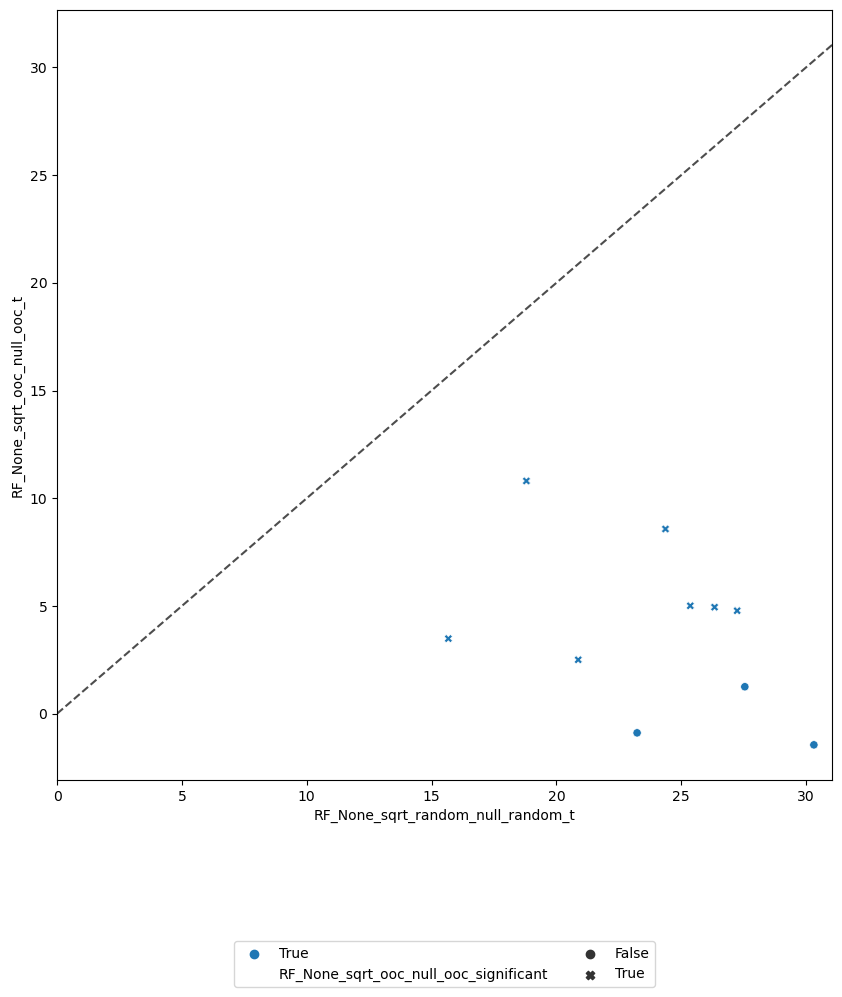

In [14]:

plt.figure(figsize=(10,10))
sns.scatterplot(data=stats, x='RF_None_sqrt_random_null_random_t', y='RF_None_sqrt_ooc_null_ooc_t', style='RF_None_sqrt_ooc_null_ooc_significant',hue="RF_None_sqrt_random_null_random_significant", )
# legend to bottom, outside of plot
plt.xlim(left=0)
ax=plt.gca()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
# draw line y=x
ax.plot(ax.get_xlim(), ax.get_xlim(), ls="--", c=".3")


OOC RF might be significant to null model? what? 

TODO: merging this with fig2A may make more sense. 

### TODO: Greedy feature selection

In [ ]:

bacdive_sim=pd.read_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221031_bacdive_simulated_data.pk")
kos_data=bacdive_sim['kos_data']
growth_data=bacdive_sim['growth_data']
carbons=bacdive_sim['carbons']
samples=bacdive_sim['samples']
mechanism=bacdive_sim['mechanism']
tree=bacdive_sim['tree']

class GreedyFeatureSelection(BinaryGrowthClassifier):
    def __init__(self,
                Model, model_params=None, tree=None,
                n_max_features=5,n_feature_subsample=None, improvement_cutoff=0.05,
                n_meta_split=10, split_method='ooc', splitter_params=None,
                pick_feature_metric='accuracy', 
                threads=1,
                save_meta_models=False, multithreading_batch=None):
        self.tree=tree
        # if distance_matrix is None:
        #     distance_matrix=calculate_distance_matrix(tree)
        #self.distance_matrix=distance_matrix

        self.Model=Model
        self.model_params=model_params
        self.n_max_features=n_max_features
        self.n_feature_subsample=n_feature_subsample

        self.n_meta_split=n_meta_split
        self.split_method=split_method
        self.splitter_params=splitter_params

        self.pick_feature_metric=pick_feature_metric
        self.threads=threads
        if multithreading_batch is None:
            multithreading_batch=threads * 5
        self.multithreading_batch=multithreading_batch
        self.save_meta_models=save_meta_models
        self.improvement_cutoff=improvement_cutoff
        
        self._meta_training_data=None
        self._best_features, self._best_accuracies=None,None
        self.final_features, self.final_accuracy, self.final_model=None,None,None

    def fit(self,X,y):
        # generate splits 
        splits=[]
        samples=X.index.values
        if isinstance(self.split_method,type):
            splitter=self.split_method(**self.splitter_params)
        elif self.split_method=='random':
            splitter=RandomSplitter(**self.splitter_params)
        elif self.split_method=='ooc':
            splitter=LargeTreeTraverseOOCSplitter(tree=self.tree,growth_data=y,**self.splitter_params)
        elif self.split_method=='ooc_distmat':
            splitter=DistMatOOCSplitter(tree=self.tree,growth_data=y,**self.splitter_params)
        elif self.split_method=='leave_one_out':
            splitter=LeaveOneOutSplitter(**self.splitter_params)
        for test_samples in splitter.generate_splits(samples, self.n_meta_split):
            splits.append((np.setdiff1d(samples,test_samples),test_samples))
        
        # run meta training 
        
        best_features, best_accuracies=[],[]
        results_all=[]

        final_features,final_accuracies=None,None

        if self.threads>1:
            p=Pool(self.threads)
        for n_feature in range(self.n_max_features):
            if self.n_feature_subsample is None or self.n_feature_subsample > X.shape[1]:
                iter_=X.columns
            else:
                iter_=np.random.choice(X.columns,self.n_feature_subsample,replace=False)

            _data_split_batch=[]
            results=[]

            # Run meta models on all data splits and all possible features 
            for i_feature,new_feature in enumerate(tqdm(iter_)):
                
                if len(best_features)>0:
                    if new_feature in best_features[-1]:
                        continue
                    else:
                        features=best_features[-1]+[new_feature]
                else:
                    features=[new_feature]

                X_new=X[features]
                for i_split,(train_samples, test_samples) in enumerate(splits):
                    X_train=X_new.loc[train_samples]
                    y_train=y.loc[train_samples]
                    X_test=X_new.loc[test_samples]
                    y_test=y.loc[test_samples]

                    param=[self.Model(**self.model_params),X_train,X_test,y_train,y_test]
                    param.append({'train_samples':train_samples,'test_samples':test_samples, 'n_feature': n_feature+1, 'features':features, 'new_feature':new_feature})
                    param.append(self.save_meta_models)

                    if self.threads<=1:
                        results.append(_pickleable_run_model(*param))
                    else:
                        _data_split_batch.append(param)
                        if (len(_data_split_batch) >= self.multithreading_batch) or (i_feature==len(iter_)-1 and i_split==len(splits)-1):
                            
                            result=p.starmap(_pickleable_run_model,_data_split_batch)
                            results.extend(result)
                            _data_split_batch=[]
                        else:
                            continue
                
            # select for best features 

            scores=[]
            for params,score_ in results:
                score=params.copy()
                score.update(score_)
                score.update({'train_sample_size':len(score['train_samples']),'test_sample_size':len(score['test_samples'])})
                scores.append(score)
            results_all.extend(scores)
            scores=pd.DataFrame(scores).groupby('new_feature')[self.pick_feature_metric].mean().sort_values(ascending=False)
            best_new_feature=scores.index.values[0]
            best_new_accuracy=scores.values[0]
            
            if len(best_features)>0:
                best_features.append(best_features[-1]+[best_new_feature])
                best_accuracies.append(best_new_accuracy)
            else:
                best_features.append([best_new_feature])
                best_accuracies.append(best_new_accuracy)
            
            if len(best_accuracies)>1 and (best_accuracies[-1]/best_accuracies[-2])>self.improvement_cutoff:
                final_features,final_accuracy=best_features[-1],best_accuracies[-1]
        
        if self.threads>1:
            p.close()

        if final_features is None:
            final_features,final_accuracy=best_features[-1],best_accuracies[-1]
        
        self._meta_training_data=pd.DataFrame(results_all)
        self._best_features=best_features
        self._best_accuracies=best_accuracies
        self.final_features=final_features
        self.final_accuracy=final_accuracy 
        self.final_model=self.train_final_model(X,y,self.final_features)
        
    def train_final_model(self, X,y, final_features):
        model=self.Model(**self.model_params)
        model.fit(X[final_features],y)
        return model
    
    def predict(self,X):
        return self.final_model.predict(X[self.final_features])
    
    def get_params(self, deep=True):
        return {'final_features': self.final_features, 'final_accuracy': self.final_accuracy}


greedy_fs_params={"Model":DecisionTree, 'tree':tree,
                    "model_params":{},
                    "n_max_features":3, "n_feature_subsample":100,
                    "n_meta_split":10, "split_method":'ooc',"splitter_params":{'test_set_range':(0.1,0.2),'min_zeros':0,'min_ones':0},
                    "threads":28,"save_meta_models":True}


# Basic pipeline
pipe=PredictionPipeline(GreedyFeatureSelection,model_params=greedy_fs_params,split_method='ooc',splitter_params={'test_set_range':(0.1,0.2),'min_zeros':0,'min_ones':0}, tree=tree,
    n_splits=10,threads=1,carbons=carbons[:5])
pipe.generate_splits(kos_data,growth_data)
results=pipe.run()

results.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/20221102_feature_selection_bacdive_sim_3.pk")

## 3B: Synthetic data phase space

See figure_3b.ipynb

## 3C: feature MI 

### MI: features

In [3]:
import sklearn.metrics as metrics 

def mutual_info(arr1, arr2, signed=False):
    #return metrics.adjusted_mutual_info_score(arr1, arr2)
    mi=metrics.mutual_info_score(arr1, arr2)
    if signed:
        mi=mi*np.sign(np.corrcoef(arr1, arr2)[0,1])
    return mi

def _pickleable_cal_mi(key, past_explainer, new_explainer, y):
    if past_explainer is None:
        explainer=new_explainer
        mi=mutual_info(y, new_explainer)
    else:
        _explainers=[np.logical_and(new_explainer, past_explainer).astype(int),
                             np.logical_or(new_explainer, past_explainer).astype(int),
                             np.logical_and(np.logical_not(new_explainer), past_explainer).astype(int),
                             np.logical_or(np.logical_not(new_explainer), past_explainer).astype(int)
                             ]
        _mis=[mutual_info(y, _explainer) for _explainer in _explainers]
        _ind=np.argmax(_mis)
        mi=_mis[_ind]
        explainer=_explainers[_ind]
    
    return key, mi, explainer

def get_top_features(X, y, keep_top=1,
            max_features=5, 
            p=None):

    if keep_top!=1 and isinstance(keep_top, float):
        keep_top=int(keep_top*X.shape[1])
    features=X.columns
    past_best=None
    df=[]
    
    for i in tqdm(range(1, max_features+1), desc="Number of features"):
        _batch=[]
        # _best=None
        for feature in features:
            if past_best is None:
                _batch.append((feature, None, X[feature].values, y))
            else:
                for _past_features, _past_explainer in past_best:
                    if not feature in _past_features:
                        _batch.append((feature+','+_past_features, _past_explainer, X[feature].values, y))
        if p is None:
            _res=[_pickleable_cal_mi(*args) for args in _batch]
        else:
            _res=p.starmap(_pickleable_cal_mi, _batch)
        
        _res=pd.DataFrame(_res, columns=["features", "mi", "explainer"]).sort_values("mi", ascending=False)
        past_best=_res.iloc[:keep_top, :][['features','explainer']].values

        df.append(_res)
    df=pd.concat(df,axis=0,ignore_index=True)
    df['n_features']=df['features'].apply(lambda x: len(x.split(',')))
    df=df.sort_values(['n_features','mi'], ascending=[True,False])
    return df


In [5]:
p=Pool(28)

In [6]:
# Zeqian data 

ko_data, growth_data,carbons=zeqian['ko_data'],zeqian['growth_data'],zeqian['carbons']

df_all=[]
for c in tqdm(CARBONS, desc="Carbon"):
    y=growth_data[c]
    _ind=y[y.notna()].index
    y=y.loc[_ind]
    X=ko_data.loc[_ind]

    df=get_top_features(X, y, max_features=5,keep_top=5,p=p)
    df['carbon_name']=c
    df_all.append(df)

df_all=pd.concat(df_all,axis=0)
df_all.to_pickle(f"{DIR_data}/figure_data/3C/zeqian_mi.pk")

Carbon: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [02:32<00:00, 15.29s/it]


In [7]:
df_all

,features,mi,explainer,n_features,carbon_name
0,K10439,0.325496,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, ...",1,Arabinose
1,K13875,0.309423,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ...",1,Arabinose
2,K10539,0.286960,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",1,Arabinose
3,K10537,0.286960,"[0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",1,Arabinose
4,K10538,0.274178,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...",1,Arabinose
...,...,...,...,...,...
141611,"K15633,K06325,K00001,K02455,K25182",0.199061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,Raffinose
141612,"K15633,K06324,K01876,K02455,K25182",0.199061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",5,Raffinose
141613,"K06988,K06324,K00001,K02455,K25182",0.199061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5,Raffinose
141614,"K06988,K00001,K01873,K02455,K25182",0.199061,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...",5,Raffinose


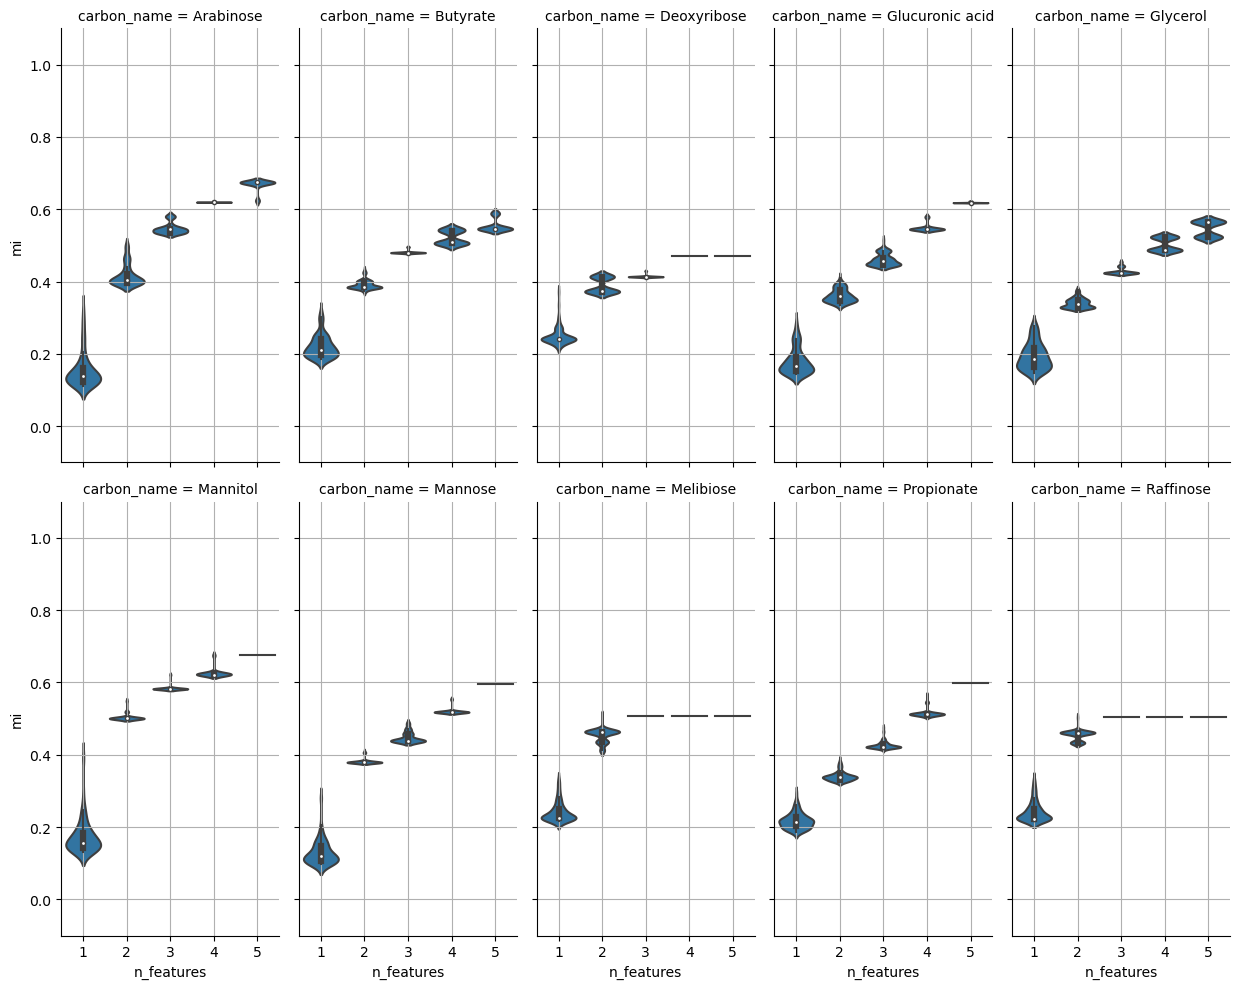

In [16]:
# Plot

df_all=pd.read_pickle(f"{DIR_data}/figure_data/3C/zeqian_mi.pk")
df_all=df_all.sort_values(by=['carbon_name','n_features','mi'], ascending=[True,True,False])
df_all['_dummy']=1
df_top=df_all.groupby(['carbon_name','n_features']).head(100)
sns.catplot(data=df_top, x="n_features", y="mi", col="carbon_name", hue='_dummy',aspect=.5,kind='violin',col_wrap=5,legend=False)

for ax in plt.gcf().axes:
    ax.set_ylim(-0.1,1.1)
    ax.grid()
    # ax.set_xticks([1,2,3,4,5])
    # ax.set_xticklabels([1,2,3,4,5])
    # ax.set_xlabel("Number of features")
    # ax.set_ylabel("Mutual information")
    # ax.set_title(ax.get_title().split('=')[1])
    # ax.legend_.remove()
# sns.swarmplot(data=df_top, x="n_features", y="mi", color=".25", ax=ax)


### MI training vs test

In [ ]:
import sklearn.metrics as metrics 
from scipy.stats import pearsonr

def mutual_info(arr1, arr2, signed=False):
    #return metrics.adjusted_mutual_info_score(arr1, arr2)
    mi=metrics.mutual_info_score(arr1, arr2)
    if signed and mi!=0:
        mi=mi*np.sign(pearsonr(arr1,arr2))
    return mi

def _pickleable_cal_split_mi(key, past_explainer_train, new_explainer_train, y_train,
                                past_explainer_test, new_explainer_test, y_test,
                                signed):
    if past_explainer_train is None:
        explainer_train=new_explainer_train
        explainer_test=new_explainer_test
        mi_train=mutual_info(y_train, new_explainer_train,signed)
        mi_test=mutual_info(y_test, new_explainer_test,signed)
        
    else:
        _explainers=[np.logical_and(new_explainer_train, past_explainer_train).astype(int),
                             np.logical_or(new_explainer_train, past_explainer_train).astype(int),
                             np.logical_and(np.logical_not(new_explainer_train), past_explainer_train).astype(int),
                             np.logical_or(np.logical_not(new_explainer_train), past_explainer_train).astype(int)
                             ]
        _mis=[mutual_info(y_train, _explainer,signed) for _explainer in _explainers]
        _ind=np.argmax(np.abs(_mis))
        mi_train=_mis[_ind]
        explainer_train=_explainers[_ind]

        if _ind==0:
            explainer_test=np.logical_and(new_explainer_test, past_explainer_test).astype(int)
        elif _ind==1:
            explainer_test=np.logical_or(new_explainer_test, past_explainer_test).astype(int)
        elif _ind==2:
            explainer_test=np.logical_and(np.logical_not(new_explainer_test), past_explainer_test).astype(int)
        elif _ind==3:
            explainer_test=np.logical_or(np.logical_not(new_explainer_test), past_explainer_test).astype(int)
        
        mi_test=mutual_info(y_test, explainer_test,signed)
    
    return key, mi_train, explainer_train, mi_test, explainer_test

def get_top_features_split(X_train, y_train, X_test, y_test, keep_top=1,
            max_features=5, signed=True,
            p=None):

    if keep_top!=1 and isinstance(keep_top, float):
        keep_top=int(keep_top*X_train.shape[1])
    features=X_train.columns
    past_best=None
    df=[]
    
    for i in tqdm(range(1, max_features+1), desc="Number of features"):
        _batch=[]
        # _best=None
        for feature in features:
            if past_best is None:
                _batch.append((feature, None, X_train[feature].values, y_train, 
                                        None, X_test[feature].values, y_test,
                                signed))
            else:
                for _past_features, _past_explainer_train,_past_explainer_test in past_best:
                    if not feature in _past_features:
                        _batch.append((feature+','+_past_features, _past_explainer_train, X_train[feature].values, y_train,
                                        _past_explainer_test, X_test[feature].values, y_test,
                                        signed))
        if p is None:
            _res=[_pickleable_cal_split_mi(*args) for args in _batch]
        else:
            _res=p.starmap(_pickleable_cal_split_mi, _batch)
        
        _res=pd.DataFrame(_res, columns=["features", "mi_train", "explainer_train",'mi_test','explainer_teset']).sort_values("mi_train", ascending=False)
        past_best=_res.iloc[:keep_top, :][['features','explainer_train','explainer_test']].values

        df.append(_res)
    df=pd.concat(df,axis=0,ignore_index=True)
    df['n_features']=df['features'].apply(lambda x: len(x.split(',')))
    df=df.sort_values(['n_features','mi_train'], ascending=[True,False])
    return df

In [ ]:
splitter=RandomSplitter(test_set_ratio=0.2)
c='Arabinose'




# Figure 4

## 4A. KEGG restricted models

See figure_4A.ipynb

# Archive

In [ ]:
# # Run this cell for testing 

# threads=1

# models={'RF':[RF,None], 'NN': [NearestNeighbor,None], "LogisticRegression":[LassoLogisticRegression,{'C':1.0, 'penalty':'l1','solver':'liblinear'}]}


# split_params={'random': {
#                  'split_method':'random',
#                  'splitter_params': {'test_set_ratio':0.2}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         'ooc': {
#                  'split_method':'ooc',
#                  'splitter_params': {'test_set_range':(0.1,0.25), 'min_zeros':0, 'min_ones':0, 'time_out_iter':None}, 
#                  'n_splits':2,
#                  'threads': threads,
#                  'save_models':False
#                  },
#         # 'loo':{
#         #          'split_method':'leave_one_out',
#         #          'splitter_params': {}, 
#         #          'n_splits':2,
#         #          'threads': threads,
#         #          'save_models':False
#         #          }
#         }

## 2A

In [ ]:
# FBA
# The standard pipeline class doesn't work well for this because it checks that the training set and test set must have non-zero samples. Borrow the _pickleable_run_model function. 

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba'
results_all.append(results)

fba_paras={c:{'c':c,
              'growth':"/home/zeqianli/project/zeqian/Carbon/data/zeqian/fba_concatenated/zeqian_fba_gapfill.csv",
              'growth_threshold':0.05} for c in CARBONS}

split_method={c:[growth_data.index.values] for c in CARBONS}
pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method=split_method,threads=1)
#pipe=PredictionPipeline(FBAClassifier,model_params=fba_paras,split_method='random',splitter_params={'test_set_ratio':0.2},threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='fba_gapfill'
results_all.append(results)

Training models...: 100%|██████████| 10/10 [00:00<00:00, 25.77it/s]


In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_all.append(results_bernoulli)

Training models...: 100%|██████████| 1000/1000 [00:01<00:00, 568.08it/s]


In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/zeqian/zeqian_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('zeqian_','')
X=X.loc[zeqian['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1,p=None)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results_all.append(results)


Training models...: 100%|██████████| 1000/1000 [06:55<00:00,  2.41it/s]


In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=1)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

Training models...: 100%|██████████| 1000/1000 [01:13<00:00, 13.62it/s]


## Matti

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk")

# results_all.append(results_bernoulli)

Training models...: 100%|██████████| 11800/11800 [00:22<00:00, 524.73it/s]


In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

Training models...: 100%|███████████████████████████████████████████████████████████████| 11800/11800 [10:47<00:00, 18.23it/s]


In [ ]:

# Nearest neighbor, 16S
from genomics_utils import IO
sixteenS_data=IO.read_fasta(f"{DIR_data}/matti/matti_16S.aligned.fna",df=True)
sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
X.index=X.index.str.replace('matti_','')
X=X.loc[matti['samples']]

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
pipe.generate_splits(X,growth_data)
results=pipe.run()
results['model']='nn_16S'
results.to_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")
# results_all.append(results)


Training models...: 100%|███████████████████████████████████████████████████████████████| 11800/11800 [34:45<00:00,  5.66it/s]


In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_genome.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_nn_16S.pk")],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")

(-0.1, 1.1)

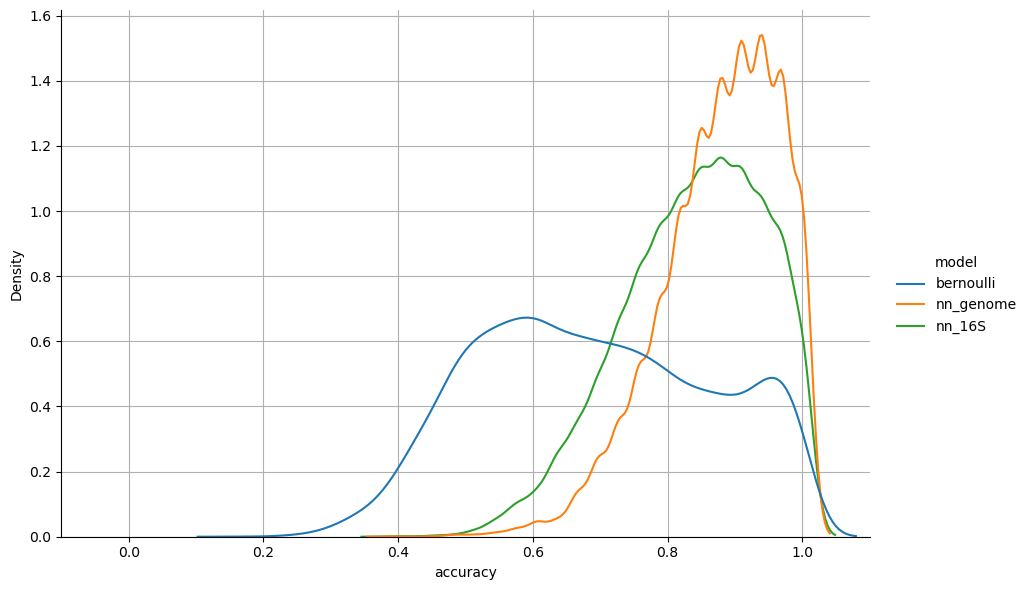

In [ ]:
# Plot
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/matti_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)


TODO: OOC

## Bacdive

In [ ]:
# Run this cell for multithreading. Recycle the same Pool. Do not open multiple pools. 
p=Pool(28)

Process ForkPoolWorker-14:
Process ForkPoolWorker-4:
Process ForkPoolWorker-25:
Process ForkPoolWorker-26:
Process ForkPoolWorker-20:
Process ForkPoolWorker-28:
Process ForkPoolWorker-5:
Process ForkPoolWorker-10:
Process ForkPoolWorker-9:
Process ForkPoolWorker-6:
Process ForkPoolWorker-19:
Process ForkPoolWorker-3:
Process ForkPoolWorker-22:
Process ForkPoolWorker-23:
Process ForkPoolWorker-16:
Process ForkPoolWorker-24:
Process ForkPoolWorker-1:
Process ForkPoolWorker-2:
Process ForkPoolWorker-12:
Process ForkPoolWorker-21:
Process ForkPoolWorker-8:
Process ForkPoolWorker-17:
Process ForkPoolWorker-7:
Process ForkPoolWorker-27:
Process ForkPoolWorker-18:
Process ForkPoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process ForkPoolWorker-11:
Traceback (most recent call last):
Process ForkPoolWorker-15:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "

In [ ]:
ko_data, growth_data, tree,carbons=bacdive['ko_data'],bacdive['growth_data'],bacdive['tree'],bacdive['carbons']

In [ ]:
# Bernoulli null
pipe=PredictionPipeline(BernoulliNull,split_method='random',splitter_params={'test_set_ratio':0.2},
                        threads=1,n_splits=100,p=None,carbons=carbons,save_models=False, 
                       ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_bernoulli.pk")
pipe.generate_splits(ko_data,growth_data)
results_bernoulli=pipe.run()
results_bernoulli['model']='bernoulli'
results_bernoulli.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk")

# results_all.append(results_bernoulli)

Training models...:  56%|███████████████████████████████████████████████████████████▏                                              | 12297/22000 [00:50<01:01, 157.46it/s]/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/zeqianli/scratch-midway3/miniconda3/envs/zeqian/lib/python3.11/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zeqianli/scratch-midway3/minicon

In [ ]:
# Nearest neighbor, genome

pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
                        split_method='random',splitter_params={'test_set_ratio':0.2},
                        n_splits=20,threads=28,p=p,carbons=carbons,save_models=False,
                        ff_results=f"{DIR_data}/figure_data/2B/cache/bacdive_nn_genome.pk")
pipe.generate_splits(ko_data,growth_data)
results=pipe.run()
results['model']='nn_genome'
results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
# results_all.append(results)

# results_all=pd.concat(results_all,axis=0,ignore_index=True)
# results_all.to_pickle("/home/zeqianli/project/zeqianli/Kuehn/Carbon/data/figure_data/2A/models_results.pk")

Changed to /home/zeqianli/project/zeqian/Carbon/data/figure_data/2B/cache/bacdive_nn_genome_0.pk. 


Training models...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4360/4360 [02:59<00:00, 24.26it/s]


In [ ]:

# Nearest neighbor, 16S
# from genomics_utils import IO
# sixteenS_data=IO.read_fasta(f"{DIR_data}/bacdive/bacdive_16S.aligned.fna",df=True)
# sixteenS_data=pd.DataFrame([list(s) for s in sixteenS_data.seq],index=sixteenS_data.id)
# X=sixteenS_data.replace(['-','A','U','C','G'],[0,1,2,3,4])
# X.index=X.index.str.replace('bacdive_','')
# X=X.loc[bacdive['samples']]

# pipe=PredictionPipeline(NearestNeighbor,model_params={'n_neighbors':1},
#                         split_method='random',splitter_params={'test_set_ratio':0.2},
#                         n_splits=100,threads=28,p=p,carbons=carbons,save_models=False)
# pipe.generate_splits(X,growth_data)
# results=pipe.run()
# results['model']='nn_16S'
# results.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_16S.pk")

# results_all.append(results)


KeyboardInterrupt: 

In [ ]:
results_all=pd.concat([pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_bernoulli.pk"),
                    pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_nn_genome.pk")
                    ],axis=0,ignore_index=True)
results_all.to_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")

(-0.1, 1.1)

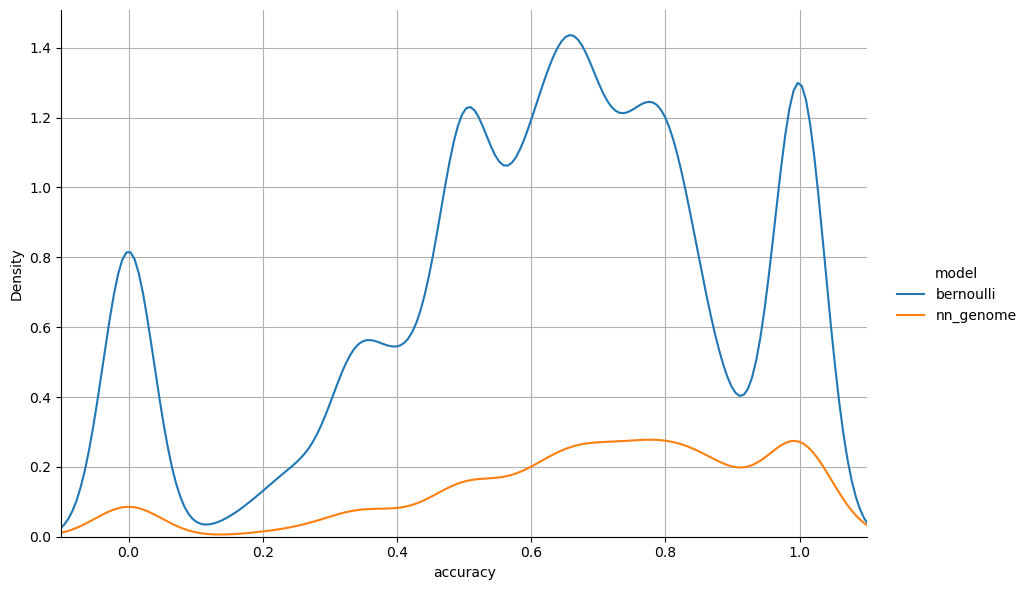

In [ ]:
results_all=pd.read_pickle(f"{DIR_data}/figure_data/2B/bacdive_models_results.pk")
sns.displot(data=results_all, x='accuracy',hue='model',kind='kde',height=6, aspect=1.5,)
#sns.stripplot(data=results_all[results_all['model'].str.contains('fba')], x='carbon_name',y='accuracy',hue='model',legend=False,jitter=False,dodge=True)

ax=plt.gca()
ax.grid()
ax.set_xlim(-0.1,1.1)
# x axis rotate 90 degree
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

